In [1]:
"studying different binning methods"

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams.update({'font.size': 12})

import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zarr

from msi_zarr_analysis.utils.autocrop import autocrop
from msi_zarr_analysis.utils.iter_chunks import iter_loaded_chunks

## Dataset

In [2]:
r13 = zarr.open_group("../datasets/comulis13.zarr/", mode='r')
r14 = zarr.open_group("../datasets/comulis14.zarr/", mode='r')
r15 = zarr.open_group("../datasets/comulis15.zarr/", mode='r')

## Binning strategies

### Uniform

In [3]:
def binning_bounds_uniform(mz_lo: float, mz_hi: float, *, n_bins: int = None, bin_width: float = None):
    ""
    # param check
    assert (n_bins is None) != (bin_width is None), "exactly one of n_bins, bin_width should be specified"

    mz_lo, mz_hi = float(mz_lo), float(mz_hi)
    
    if n_bins is None:
        bin_width = float(bin_width)
        n_bins = np.round((mz_hi - mz_lo) / bin_width)
    else:
        n_bins = int(n_bins)
        bin_width = (mz_hi - mz_lo) / n_bins

    # linspace
    bounds = np.linspace(mz_lo, mz_hi, num=n_bins+1)
    
    return bounds[:-1], bounds[1:]

### Geometric (Geurts et al. 2005)
https://doi.org/10.1093/bioinformatics/bti494

In [4]:
def binning_bounds_geometric(mz_lo: float, mz_hi: float, *, n_bins: int = None, r: float = None):
    # param check
    assert (n_bins is None) != (r is None), "exactly one of n_bins, r should be specified"

    mz_lo, mz_hi = float(mz_lo), float(mz_hi)
    
    append_mz_hi = False
    if n_bins is None:
        r = float(r)
        n_bins = np.round((np.log(mz_hi) - np.log(mz_lo)) / np.log(1 + r))
        print(f"computed {n_bins=!r} (+/- 1)")
        
        append_mz_hi = True
    else:
        n_bins = int(n_bins)
        r = (mz_hi / mz_lo) ** (1/float(n_bins)) - 1.0
        print(f"computed {r=!r}")
    
    # geometric space
    bounds = mz_lo * (1 + r) ** np.arange(n_bins + 1)
    
    if append_mz_hi and bounds[-1] < mz_hi:
        # n_bins += 1
        bounds = np.concatenate((bounds, (mz_hi,)))
    
    return bounds[:-1], bounds[1:]

### Estimated

Doing an estimation based on a list of spectrum (possibly uneven)

In [5]:
def binning_bounds_auto(
    mz_lo: float,
    mz_hi: float,
    *spectra: "tuple[np.ndarray, np.ndarray]",
    n_bins: int,
) -> "tuple[np.ndarray, np.ndarray]":
    # param check
    n_bins = int(n_bins)
    mz_lo, mz_hi = float(mz_lo), float(mz_hi)
    
    # NOTE this needs s_len >> n_bins to work well
    # is there a valid method when s_len ~= n_bins or s_len < n_bins ?

    # make sure it's not just an iterator
    if not isinstance(spectra, (tuple, list, np.ndarray, set)):
        spectra = list(spectra)

    # estimation for the separation between the bins
    estimation = np.zeros((len(spectra), n_bins - 1))

    for idx, (s_mzs, s_int) in enumerate(spectra):
        s_len = s_mzs.size
        frac = np.arange(1, n_bins) / n_bins
        steps = np.int64(np.round(frac * s_len))

        estimation[idx, :] = s_mzs[steps]

    bounds = np.concatenate(((mz_lo,), estimation.mean(axis=0), (mz_hi,)))

    return bounds[:-1], bounds[1:]

## Illustrations

In [6]:
def get_mz_bounds(dataset: zarr.Group) -> "tuple[float, float]":
    ""
    
    z_len = dataset["/labels/lengths/0"]
    z_mzs = dataset["/labels/mzs/0"]
    
    n_len = z_len[0, 0]
    bounds = autocrop(n_len)
    
    mzs_min, mzs_max = np.inf, -np.inf
    
    for cy, cx in iter_loaded_chunks(z_mzs, *bounds, skip=2):
        c_len = n_len[cy, cx]
        c_len_max = c_len.max()
        c_mzs = z_mzs[:c_len_max, 0, cy, cx]
        
        for y, x in zip(*np.nonzero(c_len)):
            s_len = c_len[y, x]
            s_mzs = c_mzs[:s_len, y, x]

            s_mzs_min = s_mzs.min()
            if s_mzs_min < mzs_min:
                mzs_min = s_mzs_min
                if s_mzs_min == 0:
                    print(f"{cy=} {cx=} {y=} {x=} {s_len=}")

            s_mzs_max = s_mzs.max()
            if s_mzs_max > mzs_max:
                mzs_max = s_mzs_max
    
    return mzs_min, mzs_max

In [7]:
get_mz_bounds(r13)

(100.31501007080078, 1149.9957275390625)

In [8]:
get_mz_bounds(r14)

(100.31501007080078, 1149.9957275390625)

In [9]:
get_mz_bounds(r15)

(100.31500244140625, 1150.0069580078125)

In [10]:
def get_random_spectra(dataset: zarr.Group, *, count: int):
    
    z_len = dataset["/labels/lengths/0"]
    z_mzs = dataset["/labels/mzs/0"]
    z_int = dataset["/0"]
    
    # get valid indices
    n_len = z_len[0, 0]
    y_nz, x_nz = np.nonzero(n_len)
    
    # build dataframe
    spectra = pd.DataFrame()
    spectra = spectra.assign(y=y_nz, x=x_nz, length=n_len[y_nz, x_nz])
    
    # remove longest to avoid outliers in the COMULIS dataset
    spectra.drop(spectra.length.argmax(), inplace=True)
    
    # randomly sample
    spectra = spectra.sample(n=count)

    # mask
    mask = np.zeros_like(n_len)
    mask[spectra.y, spectra.x] = 1

    lst = []
    
    for cy, cx in iter_loaded_chunks(z_int, *autocrop(mask), skip=2):
        c_len = n_len[cy, cx]
        c_mask = mask[cy, cx]
        
        if c_mask.sum() == 0:
            continue
    
        c_len_max = c_len.max()
        c_mzs = z_mzs[:c_len_max, 0, cy, cx]
        c_int = z_int[:c_len_max, 0, cy, cx]
        for y, x in zip(*np.nonzero(c_mask)):
            s_len = c_len[y, x]
            lst.append((c_mzs[:s_len, y, x], c_int[:s_len, y, x]))

    return lst

In [12]:
def plot_bins(*bins: "tuple[np.ndarray, np.ndarray]", figsize):
    fig, axes = plt.subplots(nrows=len(bins), ncols=1, squeeze=False, figsize=figsize, sharex=True)

    for idx, (lo, hi) in enumerate(bins):
        ax = axes[idx][0]
        
        ax.set_title(f"Binning strategy #{idx+1}")
        
        ax.vlines(np.concatenate((lo, hi[-1:])), 0.0, 1.0)
    
    fig.tight_layout()

In [13]:
samples = get_random_spectra(r15, count=50)

In [17]:
mz_lo, mz_hi = 100, 1050  # include r15 as well
n_bins = 50

computed r=0.04815083822215227


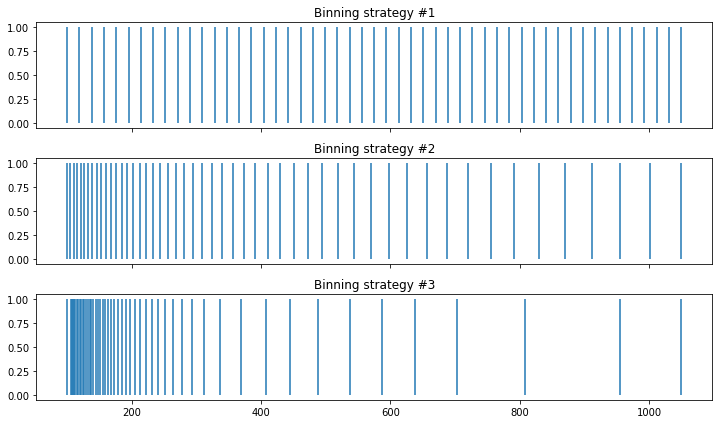

In [18]:
plot_bins(
    binning_bounds_uniform(mz_lo, mz_hi, n_bins=n_bins),
    binning_bounds_geometric(mz_lo, mz_hi, n_bins=n_bins),
    binning_bounds_auto(mz_lo, mz_hi, *samples, n_bins=n_bins),
    figsize=(10, 6)
)

In [21]:
bin_lo, bin_hi = binning_bounds_auto(mz_lo, mz_hi, *samples, n_bins=32768)
np.savez("bins32768.npz", bin_lo=bin_lo, bin_hi=bin_hi)